## Predicting WNV Prevalence at a County Level in the United States Using AlphaEarth Embedding Data (2017 - 2024)

## Contents:


##### 1. Converting Google Earth Assets to CSV files  

##### 2. Appending WNV case data to each file

##### 3. Obtatining population data from 2017 to 2024 for all counties

##### 4. WNV case data visualized at a national level   

##### 5. Machine learning model evaluation 

In [1]:
from pathlib import Path
from glob import glob
import sys
from dotenv import load_dotenv
import os
from datacommons_client.client import DataCommonsClient

# utils import error: add wnv_embeddings as root
PROJECT_ROOT = Path.cwd().parents[1]  # <-- wnv_embeddings
sys.path.insert(0, str(PROJECT_ROOT))

from utils.utils import convert_to_df
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import ee

### 1. Converting Google Earth Assets to ~50 CSV Files 

* National average embeddings data per county for all states (2017 to 2024).
* Each asset represents one state (according to the FIPS code).
* State FIPS Codes available here: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

#### Saving as CSV to `.\notebooks\national_embeddings\all_embeddings_csvs`

Using the `convert_to_df()` function from `utils.py`: 

In [ ]:
# will prompt you to authorize access to GEE
# this is needed to obtain assets from the cloud saved under your account
ee.Authenticate()

# enter your own registered project name here
ee.Initialize(project="wnv-embeddings")

In [ ]:
state_fips_codes = [
    "01", "02", "04", "05", "06", "08", "09", "10", "11", "12",
    "13", "15", "16", "17", "18", "19", "20", "21", "22", "23",
    "24", "25", "26", "27", "28", "29", "30", "31", "32", "33",
    "34", "35", "36", "37", "38", "39", "40", "41", "42", "44",
    "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56"
  ]

In [ ]:
# =============CONVERT GEE ASSETS TO CSVS============= #
# ONLY RUN ONCE TO CONVERT ALL 56 ASSETS AS CSV #

# now obtaining the csvs
# csv_destination = Path("all_embeddings_csvs")
# csv_destination.mkdir(parents=True, exist_ok=True)

# for fips in state_fips_codes:
# 	gee_path = f"users/angel314/{fips}_2017_2024_embeddings"
	
# 	save_to = csv_destination / f"{fips}-avg-embeddings-2017-2024.csv"

# 	convert_to_df(gee_path, True, save_to)

### 2. Appending Yearly WNV Case Data

##### Getting WNV Case Data:
* Source: https://www.cdc.gov/west-nile-virus/data-maps/historic-data.html  
* Section: "Explore county level data for 1999-2024" - "Yearly data"
	* Returns: one CSV with case data at a county level for 1999-2024
* `Location` column represents the FIPS county code for that row.
* WNV Case data is cleaned to only include relevant years and rows with at least one human disease case. 

This is a preview of WNV County Cases from 1999 to 2024.

In [ ]:
cases = pd.read_csv("./national_wnv_case_data/wnv_county_cases_1999_2024.csv")
cases.sample(5)

,FullGeoName,Year,Location,Activity,Total human disease cases,Neuroinvasive disease cases,**Presumptive viremic blood donors,Notes
16252,"CA, Santa Clara",2007,6085,Human infections and non-human activity,4.0,1.0,0.0,NaN
4456,"CO, Pitkin",2019,8097,Human infections,1.0,0.0,0.0,NaN
26347,"VA, Scott",2002,51169,Non-human activity,0.0,0.0,0.0,NaN
13116,"PA, Indiana",2012,42063,Non-human activity,0.0,0.0,0.0,NaN
7243,"OH, Meigs",2017,39105,Human infections and non-human activity,1.0,1.0,0.0,NaN


In [ ]:
###### filtering ######

# remove entries that come before 2017
cases = cases[cases["Year"]>=2017]
# remove any rows with 0 total human disease cases
cases = cases[cases["Total human disease cases"]>0]
# only keep relevant columns
cases = cases.drop(columns=["FullGeoName", "Activity", "Neuroinvasive disease cases", "**Presumptive viremic blood donors", "Notes"]).reset_index(drop=True)
cases

,Year,Location,Total human disease cases
0,2024,1001,2.0
1,2024,1003,2.0
2,2024,1021,1.0
3,2024,1043,2.0
4,2024,1047,1.0
...,...,...,...
4006,2017,55141,2.0
4007,2017,56003,1.0
4008,2017,56013,3.0
4009,2017,56015,2.0


In [ ]:
cases = cases.groupby(["Year","Location"]).agg("sum").reset_index()
cases

,Year,Location,Total human disease cases
0,2017,1001,6.0
1,2017,1003,3.0
2,2017,1007,1.0
3,2017,1011,1.0
4,2017,1015,2.0
...,...,...,...
4006,2024,55133,1.0
4007,2024,55139,1.0
4008,2024,55141,1.0
4009,2024,56015,1.0


In [ ]:
# convert from long format to wide format
# each row represents one location
# each location has sum of cases for 2017 - 2024.

# columns="Year" -> each unique year is a column
# values="cases" -> numbers to fill pivot table
# take sum of all entries for the the same location and year

# reset_index to move "Location" column to the right.

cases_wide = (cases.pivot_table(index="Location", columns="Year", values="Total human disease cases", aggfunc="sum", fill_value=0).add_prefix("Cases_").reset_index())
cases_wide

Year,Location,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
0,1001,6.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0
1,1003,3.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0
2,1007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1015,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
1607,56025,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0
1608,56029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1609,56031,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1610,56033,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Saving this cleaned dataframe to a csv for future use.

In [ ]:
cases_wide.to_csv("./national_wnv_case_data/agg_wnv_county_cases_2017_2024.csv")

Now all that is left is to merge with the embeddings data for a fips code. 

This is a test with fips code 17 (Illinois).

In [ ]:
##### fips 17 test #####

# get csv for current fips code
path = f"./all_embeddings_csvs/17-avg-embeddings-2017-2024.csv"
# load in the csv 
df = pd.read_csv(path)
df

,A00_2017,A00_2018,A00_2019,A00_2020,A00_2021,A00_2022,A00_2023,A00_2024,A01_2017,A01_2018,...,A62_2024,A63_2017,A63_2018,A63_2019,A63_2020,A63_2021,A63_2022,A63_2023,A63_2024,GEOID
0,-0.126185,-0.112618,-0.083152,-0.137135,-0.105750,-0.125978,-0.123757,-0.102107,-0.038990,-0.037035,...,-0.136299,0.030838,0.038678,0.028741,0.034277,0.042769,0.022800,0.033839,0.033290,17121
1,-0.119659,-0.100279,-0.086142,-0.111147,-0.091950,-0.108974,-0.110964,-0.088635,-0.035458,-0.033798,...,-0.143509,0.048798,0.048666,0.044434,0.057424,0.066643,0.039234,0.050398,0.049886,17005
2,-0.121869,-0.106163,-0.089410,-0.093877,-0.100690,-0.095218,-0.117983,-0.091646,-0.032314,-0.017284,...,-0.147811,0.030798,0.035180,0.038207,0.042865,0.044161,0.031365,0.031765,0.035637,17083
3,-0.120115,-0.113954,-0.098588,-0.113361,-0.104700,-0.109215,-0.123083,-0.098814,-0.096917,-0.080333,...,-0.142231,0.030921,0.034907,0.035352,0.036025,0.049167,0.029630,0.036940,0.040171,17163
4,-0.104617,-0.090185,-0.070940,-0.106841,-0.082370,-0.101803,-0.099361,-0.082830,-0.084239,-0.075842,...,-0.129191,0.080986,0.080554,0.077953,0.085153,0.096826,0.073851,0.082292,0.084914,17027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-0.081918,-0.083240,-0.049877,-0.071286,-0.032761,-0.055054,-0.061407,-0.069657,-0.047272,-0.037998,...,-0.165051,0.045601,0.055496,0.062862,0.061943,0.088035,0.038284,0.045226,0.050090,17131
98,-0.068598,-0.065659,-0.033529,-0.056787,-0.025147,-0.045408,-0.046732,-0.061580,-0.081419,-0.070210,...,-0.154932,0.036447,0.041207,0.067978,0.053747,0.078759,0.036642,0.040094,0.035452,17161
99,-0.070369,-0.077984,-0.038843,-0.059882,-0.027230,-0.047454,-0.051155,-0.067624,-0.060634,-0.034753,...,-0.154816,0.057985,0.058326,0.064610,0.065451,0.092426,0.048008,0.046217,0.055491,17073
100,-0.063715,-0.053766,-0.017952,-0.039881,-0.024010,-0.040352,-0.044199,-0.061335,-0.044527,-0.032002,...,-0.126775,0.055892,0.071999,0.090880,0.094341,0.123831,0.065502,0.072743,0.072798,17103


In [ ]:
df_merged = pd.merge(df, cases_wide, left_on="GEOID", right_on="Location", how="left").fillna(0).drop(columns=["Location"])
df_merged

,A00_2017,A00_2018,A00_2019,A00_2020,A00_2021,A00_2022,A00_2023,A00_2024,A01_2017,A01_2018,...,A63_2024,GEOID,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
0,-0.126185,-0.112618,-0.083152,-0.137135,-0.105750,-0.125978,-0.123757,-0.102107,-0.038990,-0.037035,...,0.033290,17121,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.119659,-0.100279,-0.086142,-0.111147,-0.091950,-0.108974,-0.110964,-0.088635,-0.035458,-0.033798,...,0.049886,17005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.121869,-0.106163,-0.089410,-0.093877,-0.100690,-0.095218,-0.117983,-0.091646,-0.032314,-0.017284,...,0.035637,17083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.120115,-0.113954,-0.098588,-0.113361,-0.104700,-0.109215,-0.123083,-0.098814,-0.096917,-0.080333,...,0.040171,17163,1.0,2.0,2.0,0.0,0.0,1.0,4.0,3.0
4,-0.104617,-0.090185,-0.070940,-0.106841,-0.082370,-0.101803,-0.099361,-0.082830,-0.084239,-0.075842,...,0.084914,17027,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,-0.081918,-0.083240,-0.049877,-0.071286,-0.032761,-0.055054,-0.061407,-0.069657,-0.047272,-0.037998,...,0.050090,17131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,-0.068598,-0.065659,-0.033529,-0.056787,-0.025147,-0.045408,-0.046732,-0.061580,-0.081419,-0.070210,...,0.035452,17161,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
99,-0.070369,-0.077984,-0.038843,-0.059882,-0.027230,-0.047454,-0.051155,-0.067624,-0.060634,-0.034753,...,0.055491,17073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-0.063715,-0.053766,-0.017952,-0.039881,-0.024010,-0.040352,-0.044199,-0.061335,-0.044527,-0.032002,...,0.072798,17103,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Iterating Over `all_embeddings_csvs` to add WNV Human cases for each year.

In [ ]:
for code in state_fips_codes:
  # get csv for current fips code
	path = f"./all_embeddings_csvs/{code}-avg-embeddings-2017-2024.csv"
  # load in the csv 
	df = pd.read_csv(path)
	df_merged = pd.merge(df, cases_wide, left_on="GEOID", right_on="Location", how="left").fillna(0).drop(columns=["Location"])

	df_merged.to_csv(f"./all_embeddings_with_cases/cleaned-{code}-avg-embeddings-2017-2024.csv")

### 3. Obtaining and Appending County Population Data:

* Using Data Commons API:

	* https://docs.datacommons.org/what_is.html 

	* Basically allows us to query specific statistical questions and get one unified result.

	* There is an option to query for counties as well using FIPS codes: https://datacommons.org/browser/County 

County population data is needed for each year to normalize based on this formula:

$\textnormal{Cases per 100k} = \frac{\textnormal{Number of disease cases}}{\textnormal{County population}} \times 100,000$

Normalized cases (cases per 100k) will be the target variable when measuring machine learning models' performance.

note: api.census.gov does not have consistent and updated data for 2017 - 2024 county populations.

In [ ]:
load_dotenv()

client = DataCommonsClient(api_key=os.getenv("COMMONS_API_KEY"))

In [ ]:
##### Cook County 2017 Population Test #####

df_popn_test = client.observations_dataframe(variable_dcids="Count_Person", entity_dcids="geoId/17031", date="2017")

df_popn_test

,date,entity,entity_name,variable,variable_name,facetId,importName,measurementMethod,observationPeriod,provenanceUrl,unit,value
0,2017,geoId/17031,Cook County,Count_Person,Total population,2176550201,USCensusPEP_Annual_Population,CensusPEPSurvey,P1Y,https://www.census.gov/programs-surveys/popest...,None,5199582.0
1,2017,geoId/17031,Cook County,Count_Person,Total population,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None,5238541.0
2,2017,geoId/17031,Cook County,Count_Person,Total population,1964317807,CensusACS5YearSurvey_SubjectTables_S0101,CensusACS5yrSurveySubjectTable,None,https://data.census.gov/table?q=S0101:+Age+and...,None,5238541.0
3,2017,geoId/17031,Cook County,Count_Person,Total population,2825511676,CDC_Mortality_UnderlyingCause,None,None,https://wonder.cdc.gov/ucd-icd10.html,None,5211263.0
4,2017,geoId/17031,Cook County,Count_Person,Total population,2517965213,CensusPEP,CensusPEPSurvey,None,https://www.census.gov/programs-surveys/popest...,None,5200821.0
5,2017,geoId/17031,Cook County,Count_Person,Total population,1226172227,CensusACS1YearSurvey,CensusACS1yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None,5211263.0


### 4. Visualizations - WNV Case Count Per Year (National Level)

In [33]:
# ----- State and county shapefile paths ----- #
# shapefiles obtained from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php on Feb. 4, 2026
STATES_PATH = "../national_embeddings/shapefiles/tl_2025_us_state/tl_2025_us_state.shp"
COUNTIES_PATH = "../national_embeddings/shapefiles/tl_2025_us_county/tl_2025_us_county.shp"
WATER_PATH = "../national_embeddings/shapefiles/great_lakes_usnic/GL260205_lam.shp"

# ----- Get state and county geographies (and great lakes) ----- #
states = gpd.read_file(STATES_PATH)
counties = gpd.read_file(COUNTIES_PATH)
water = gpd.read_file(WATER_PATH)

# ----- Project to EPSG:3857 and adjust boundaries ----- #
states = states.to_crs(3857)
water = water.to_crs(states.crs)
# ignore Alaska, Hawaii, Guam, Puerto Rico, Commonwealth of the Northern Mariana Islands, American Samoa, Virgin Islands (no cases)
# including these also unneccessarily enlarge the zoom on the US map 
exclude = ["AK","HI","GU","PR","MP","AS","VI"]
exclude_sfips = ['02', '60', '15', '78', '72', '69', '66']
# historically have had no cases: # https://health.hawaii.gov/docd/disease_listing/west-nile-virus/
# https://www.usgs.gov/faqs/where-united-states-has-west-nile-virus-been-detected-wildlife
# no geoid matched with CNMI in the cases data frame

states = states[~states["STUSPS"].isin(exclude)]
counties = counties[~counties["STATEFP"].isin(exclude_sfips)]
counties = counties.to_crs(3857)

# ----- Get United States boundary ----- #
us_outline = gpd.GeoDataFrame(geometry=[unary_union(states.geometry)], crs=states.crs)

# ----- Convert all CSVs in `all_embeddings_with_cases` to one long dataframe to merge geographies ----- #
files = glob("../national_embeddings/all_embeddings_with_cases/*.csv")
dfs = [pd.read_csv(f) for f in files]

# drop first unnamed col
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.drop(df_all.columns[0], axis=1)

# convert GEOID to str and add a trailing zeros to conform to 5-digit fips
df_all["GEOID"] = df_all["GEOID"].astype(str).str.zfill(5)

# both use "GEOID" as unique identifier
counties_geom = counties[["GEOID","geometry"]]
df_merged = pd.merge(df_all, counties_geom, on="GEOID", how="inner")
# convert df_merged to a GeoDataFrame (I need to inspect it visually)
df_merged = gpd.GeoDataFrame(df_merged, geometry=df_merged.geometry, crs=states.crs)

# only keep cases columns (embedding data is irrelevant for these visualizations)
df_merged = df_merged[['GEOID', 'Cases_2017', 'Cases_2018', 'Cases_2019', 'Cases_2020',
       'Cases_2021', 'Cases_2022', 'Cases_2023', 'Cases_2024', 'geometry']]
df_merged

,GEOID,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024,geometry
0,01053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9725303.081 3632475.902, -9725305.8..."
1,01123,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"POLYGON ((-9539601.465 3855215.347, -9539719.1..."
2,01009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9636283.555 4002238.043, -9636434.3..."
3,01115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9592671.807 3983216.588, -9592657.8..."
4,01117,4.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,"POLYGON ((-9615576.906 3954686.159, -9615577.1..."
...,...,...,...,...,...,...,...,...,...,...
3095,56039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-12362413.171 5569134.34, -12359426...."
3096,56001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-11719590.756 5029525.384, -11719590..."
3097,56013,3.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,"POLYGON ((-12170089.381 5292020.105, -12170096..."
3098,56037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-12196730.473 5012104.192, -12196744..."


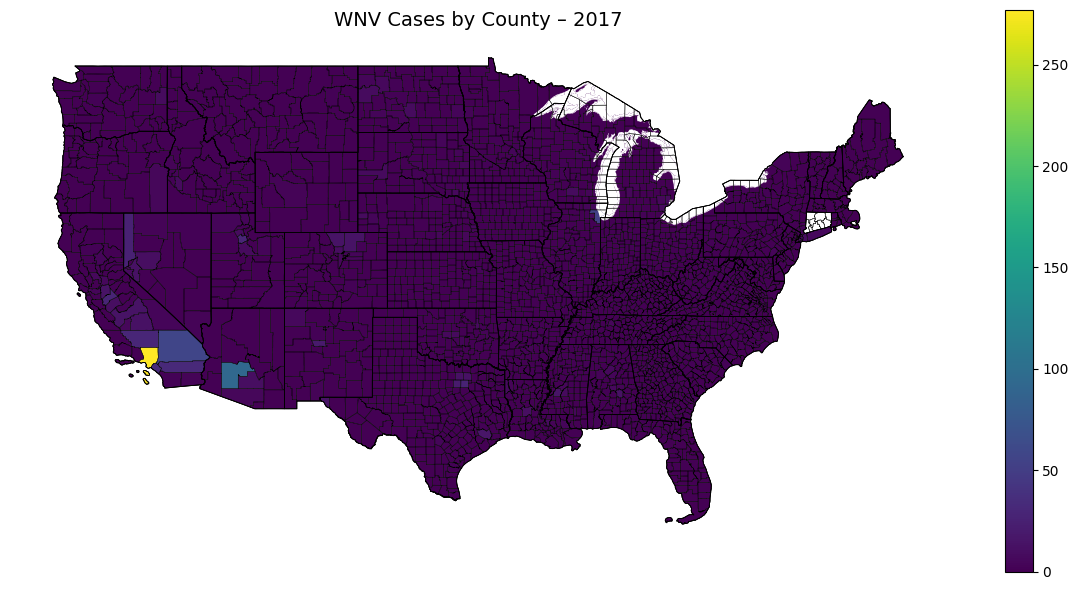

In [ ]:
for year in range(2017, 2018):
	col = f"Cases_{year}"

	fig, ax = plt.subplots(1, 1, figsize=(12, 6))

	df_merged.plot(
		column=col,
		ax=ax,
		cmap="viridis",
		legend=True
	)

	# draw US outline
	us_outline.boundary.plot(ax=ax, color="black", linewidth=0.6)
	# draw US states outline
	states.boundary.plot(ax=ax, color="black", linewidth=0.6)
	# draw US counties outline
	counties.boundary.plot(ax=ax, color="black", linewidth=0.3)
	# on top of everything, overlay great lakes 
	water.plot(ax=ax, color="blue", linewidth=0)
	# gray out connecticut specifically (no data except on 2022 available)
	ct.plot(ax=ax, color="gray")

	ax.set_title(f"WNV Cases by County – {year}", fontsize=14)
	ax.axis("off")

	plt.tight_layout()
	plt.savefig("../national_embeddings/output.png")
	plt.show()

### 5. Model Evaluation